In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import tensorflow as tf
import os
%matplotlib inline

In [2]:
# Load data
with np.load(os.path.join('data','mnist-60k.npz'), allow_pickle=False) as npz_file:
    # Load items into a dictionary
    mnist = dict(npz_file.items())
    
X = mnist['data'].astype(np.float32).reshape(-1, 28, 28, 1)
y = mnist['labels']

In [3]:
# split the data
from sklearn.model_selection import train_test_split

# Create train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.1, random_state=0)

# Split again into validation/test sets
X_cv, X_te, y_cv, y_te = train_test_split(X_te, y_te,test_size=0.6, random_state=0)

print("X_tr", X_tr.shape)
print("X_te", X_te.shape)
print("X_cv", X_cv.shape)

X_tr (54000, 28, 28, 1)
X_te (3600, 28, 28, 1)
X_cv (2400, 28, 28, 1)


In [4]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y))
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [5]:
# Create new graph
graph = tf.Graph()

# set init to indicate a new model
init = True

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    training = tf.placeholder(dtype=tf.bool)

    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)

    # Decay the learning rate - 
    learning_rate = tf.train.exponential_decay(0.001,               # start at 0.001
                                               global_step, 
                                               2000,                # 2000 steps
                                               0.95,                # 0.95 increment
                                               staircase=True)

    # Convolutional layer 1 
    conv1 = tf.layers.conv2d(
        X,                           # Input data
        filters=32,                  # 32 filters
        kernel_size=(5, 5),          # Kernel size: 5x5
        strides=(1, 1),              # Stride: 1
        padding='SAME',              # "same" padding
        activation=tf.nn.relu,       # ReLU
        kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
        name='conv1'                  # Add name
    )

    # Max pooling layer 1
    pool1 = tf.layers.max_pooling2d(
        conv1,                       # Input
        pool_size=(2, 2),            # Pool size: 2x
        strides=(2, 2),              # Stride: 2
        padding='SAME',              # "same" padding
        name='pool1'
    )

    # Convolutional layer 2
    conv2 = tf.layers.conv2d(
        pool1,                       # Input
        filters=64,                  # 64 filters
        kernel_size=(5, 5),          # Kernel size: 5x5
        strides=(1, 1),              # Stride: 1
        padding='SAME',              # "same" padding
        activation=tf.nn.relu,       # ReLU
        kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0),    # Small standard deviation
        name='conv2'                 # Add name
    )

    # Max pooling layer 2 (2x2, stride: 2) - TUNED
    pool2 = tf.layers.max_pooling2d(
        conv2,                       # input
        pool_size=(2, 2),            # pool size 2x2
        strides=(2, 2),              # stride 2
        padding='SAME'
    )

    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool2)

    # Fully connected layer
    fc1 = tf.layers.dense(
        flat_output,                 # input
        1024,                         # 256 hidden units
        activation=tf.nn.relu,       # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='fc1'
    )

    fc1 = tf.layers.dropout(fc1, rate=0.70, seed=1, training=training)

    # logits
    logits = tf.layers.dense(
        fc1,                         # input
        10,                           # One output unit per category
        activation=None,             # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer()
    )

    #loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
    loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss=loss,global_step=global_step)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    #probabilities = tf.nn.softmax(logits, name="softmax_tensor")
    
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    
    # Get weights/biases of the conv1 layer
    #with tf.variable_scope('conv1', reuse=True):
    #    W1 = tf.get_variable('kernel')
    #    b1 = tf.get_variable('bias')

    # Get weights/biases of the conv2 layer
    #with tf.variable_scope('conv2', reuse=True):
    #    W2 = tf.get_variable('kernel')
    #    b2 = tf.get_variable('bias')

    # Get weights/biases of the fully connected layer
    #with tf.variable_scope('fc1', reuse=True):
    #    W3 = tf.get_variable('kernel')
    #    b3 = tf.get_variable('bias')

In [6]:
init = False

INFO:tensorflow:Restoring parameters from ./model/mnist_model.ckpt
Epoch 00 - step 82712 - cv acc: 0.994 - train acc: 1.000 (mean) - cv cost: 0.137 - lr: 0.00012


KeyboardInterrupt: 

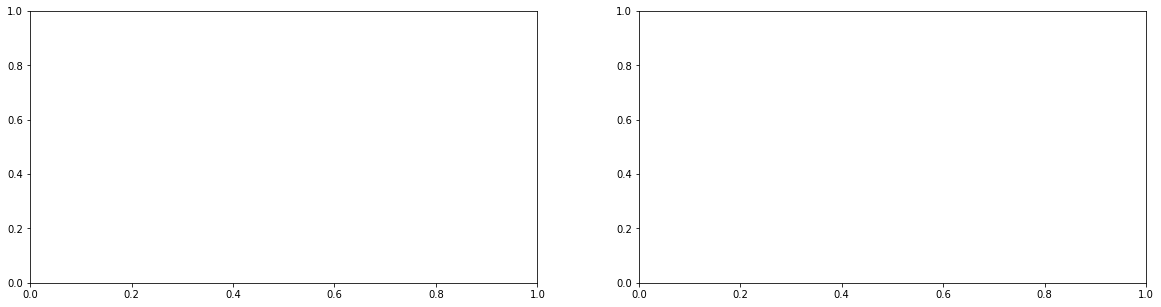

In [14]:
# Placeholders for metrics
valid_acc_values = []
valid_cost_values = []
train_acc_values = []
train_cost_values = []
dropout1_values = []

# how many epochs to run
epochs = 20

# how often to print metrics
print_every = 5

# how often to save model
checkpoint_every = 5

# whether to print or plot metrics
print_metrics = True

config = tf.ConfigProto(
    # uncomment to run on CPU
    #device_count = {'GPU': 0}
)
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.6

with tf.Session(graph=graph, config=config) as sess:
    # create a plot to be updated as model is trained
    f, ax = plt.subplots(1,2,figsize=(20,5))
    
    # create the saver
    saver = tf.train.Saver()
    
    # If the model is new initialize variables, else restore the session
    if init:
        sess.run(tf.global_variables_initializer())
    else:
        saver.restore(sess, './model/mnist_model.ckpt')
        
    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(epochs):
        # Accuracy values (train) after each batch
        batch_acc = []
        batch_cost = []

        for X_batch, y_batch in get_batches(X_tr, y_tr, 32):
            # Run training and evaluate accuracy
            _, acc_value, cost_value = sess.run([train_op, accuracy, loss], feed_dict={
                X: X_batch,
                y: y_batch,
                training: True
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)
            batch_cost.append(cost_value)

        # Evaluate validation accuracy
        valid_acc, valid_cost, lr, step = sess.run([accuracy, loss, learning_rate, global_step], feed_dict={
            X: X_cv,
            y: y_cv,
            training: False
        })
        valid_acc_values.append(valid_acc)
        valid_cost_values.append(valid_cost)
        train_acc_values.append(np.mean(batch_acc))
        train_cost_values.append(np.mean(batch_cost))
        
        if print_metrics:
            # Print progress every fifth epoch to keep output to reasonable amount
            if(epoch % print_every == 0):
                print('Epoch {:02d} - step {} - cv acc: {:.3f} - train acc: {:.3f} (mean) - cv cost: {:.3f} - lr: {:.5f}'.format(
                    epoch, step, valid_acc, np.mean(batch_acc), valid_cost, lr
                ))
        else:
            # draw a plot
            ax[0].cla()
            ax[0].plot(valid_acc_values, color="red", label="Validation")
            ax[0].plot(train_acc_values, color="blue", label="Training")
            ax[0].set_title('Validation accuracy: {:.3f} (mean last 3)'.format(np.mean(valid_acc_values[-3:])))

            ax[0].set_xlabel('epoch')
            ax[0].set_ylabel('accuracy')
            ax[1].cla()
            ax[1].plot(valid_cost_values, color="red", label="Validation")
            ax[1].plot(train_cost_values, color="blue", label="Training")
            ax[1].set_title('Validation cost: {:.3f} (mean last 3)'.format(np.mean(valid_cost_values[-3:])))
            ax[1].set_xlabel('epoch')
            ax[1].set_ylabel('cost')
            ax[1].legend()
            ax[0].legend()

            display.display(plt.gcf())
            display.clear_output(wait=True)    
        
        # save checkpoint every nth epoch except the first
        if((epoch != 0) & (epoch % checkpoint_every == 0)):
            print("Saving checkpoint")
            # save the model
            save_path = saver.save(sess, "./model/mnist_model.ckpt")
    
            # Now that model is saved set init to false so we don't need to constantly retrain it
            init = False
        
    # print results of last epoch
    print('Epoch {} - step {} - cv acc: {:.3f} - train acc: {:.3f} (mean) - cv cost: {:.3f}'.format(
                epochs, step, valid_acc, np.mean(batch_acc), valid_cost
            ))
            
    # Check on the test data
    test_acc = sess.run(accuracy, feed_dict={
        X: X_te,
        y: y_te,
        training: False
    })
    
    # save the model
    print("Saving model")
    save_path = saver.save(sess, "./model/mnist_model.ckpt")
    init = False
    

# update the plot
f, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(valid_acc_values, color="red", label="Validation")
ax[0].plot(train_acc_values, color="blue", label="Training")
ax[0].set_title('Validation accuracy: {:.3f} (mean last 3)'.format(np.mean(valid_acc_values[-3:])))
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[1].plot(valid_cost_values, color="red", label="Validation")
ax[1].plot(train_cost_values, color="blue", label="Training")
ax[1].set_title('Validation cost: {:.3f} (mean last 3)'.format(np.mean(valid_cost_values[-3:])))
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('cost')
plt.legend()
plt.show()

print("Accuracy (test set):",test_acc)

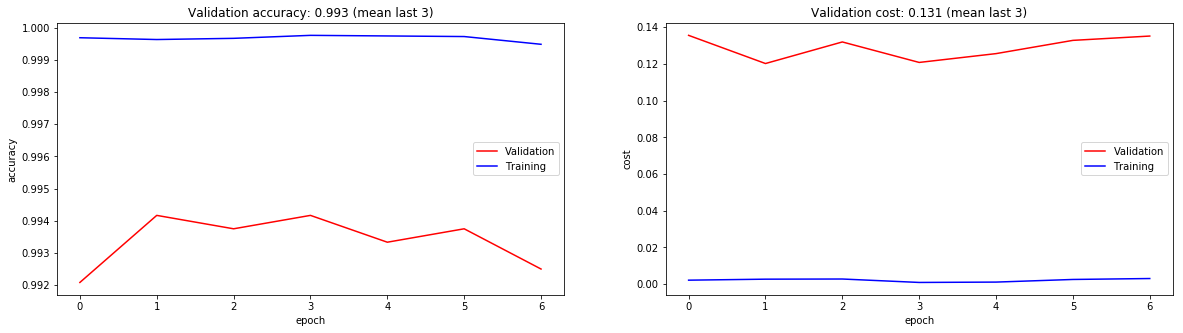

Accuracy (test set): 0.99277776


In [13]:
# update the plot
f, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(valid_acc_values, color="red", label="Validation")
ax[0].plot(train_acc_values, color="blue", label="Training")
ax[0].set_title('Validation accuracy: {:.3f} (mean last 3)'.format(np.mean(valid_acc_values[-3:])))
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[1].plot(valid_cost_values, color="red", label="Validation")
ax[1].plot(train_cost_values, color="blue", label="Training")
ax[1].set_title('Validation cost: {:.3f} (mean last 3)'.format(np.mean(valid_cost_values[-3:])))
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('cost')
plt.legend()
plt.show()

print("Accuracy (test set):",test_acc)

In [12]:
with tf.Session(graph=graph, config=config) as sess:
    saver.restore(sess, './model/mnist_model.ckpt')
    
    # Check on the test data
    test_acc = sess.run(accuracy, feed_dict={
        X: X_te,
        y: y_te,
        training: False
    })

INFO:tensorflow:Restoring parameters from ./model/mnist_model.ckpt
